# Advanced Use Cases

- Setup

In [ ]:
####################### Change the setup below according to your choice of API #######################
from langchain_huggingface import HuggingFaceEmbeddings
# embeddings
model_name = "sentence-transformers/all-MiniLM-L6-v2"
text = "Write a short poem about programming."
embeddings = HuggingFaceEmbeddings(model_name=model_name)

# chatllm multimodal (vision/text)
from langchain_openai import ChatOpenAI
chatllm = ChatOpenAI(model="gpt-3.5-turbo")



### Fine-tuning LLMs with LangChain
You can use an LLM to generate data examples to finetune another LLM

In [ ]:
from langchain.callbacks import FileCallbackHandler
from langchain_openai import OpenAI, ChatOpenAI
import json
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate

# 1. Define the prompt with strict formatting instructions
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful data generation assistant."),
    ("user", 
     """Generate 5 training examples for fine-tuning an AI assistant to answer customer service queries.
Each example should have:
1. A customer question about our e-commerce platform
2. A helpful, concise answer

Respond ONLY with a JSON array of objects. Do not include any explanation, markdown, or text.
Format:
[
  {{ "input": "...", "output": "..." }},
  ...
]""")
])

# 2. Define the parser
parser = JsonOutputParser()

# 3. Define the model
llm = chatllm 

# 4. Chain prompt → model → parser
chain = prompt | llm | parser

# 5. Invoke the chain with correct input ({} because no input variables)
training_data_raw = chain.invoke({})

# 3. Save to JSONL file (OpenAI format)
with open("files/training_data.json", "w") as f:
    for item in training_data_raw:
        f.write(json.dumps({"messages": [
            {"role": "user", "content": item["input"]},
            {"role": "assistant", "content": item["output"]}
        ]}) + "\n")

# 4. Use OpenAI CLI to fine-tune (run in terminal) or hagging face trl 
# openai api fine_tunes.create -t training_data.jsonl -m gpt-3.5-turbo

### Multi-modal Chains with LCEL

content="The image depicts a dog running through a field of grass. \n\nThe dog appears to be a Golden Retriever, with a light golden coat and floppy ears that are blowing back as it runs. Its mouth is open, and its tongue is hanging out. The dog's fur appears to be blowing in the wind, and its front right leg is extended in front of it as if it is mid-stride.\n\nThe background is blurry but appears to be a green field with trees in the distance. The overall atmosphere suggests a sunny day, with the sun shining down on the dog and casting a warm glow over the scene." additional_kwargs={} response_metadata={} id='run-2d6ef404-5c69-40ec-bdff-3af6d2cd4527-0'


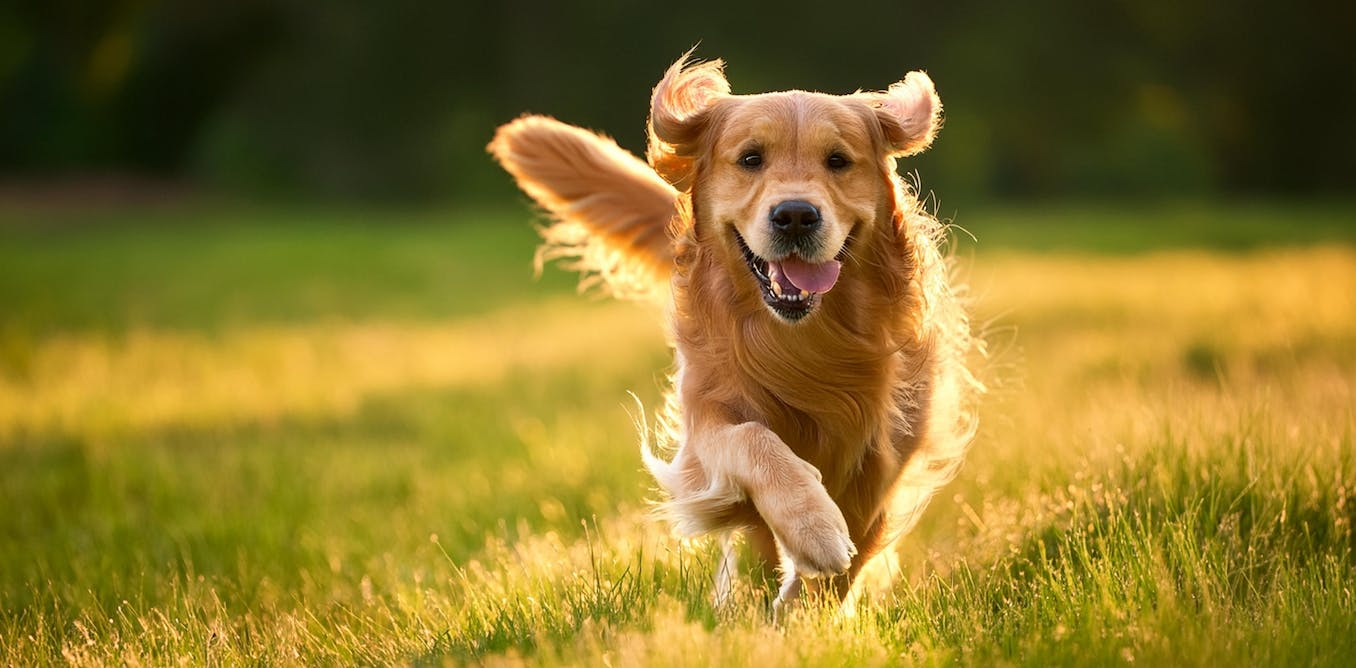

In [84]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from PIL import Image
import requests
from io import BytesIO

# 1. Load image
image_url = "https://images.theconversation.com/files/625049/original/file-20241010-15-95v3ha.jpg?ixlib=rb-4.1.0&rect=12%2C96%2C2671%2C1335&q=45&auto=format&w=1356&h=668&fit=crop"
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))


# 2. Create message with image
message = HumanMessage(
    content=[
        {"type": "text", "text": "Describe what you see in this image."},
        {
            "type": "image_url",
            "image_url": {
                "url": f"{image_url}" # Base64 encoded image
            }
        }
    ]
)

# 4. Get response
response = chatllm.invoke([message])
print(response)
image.show()

In [89]:
# 5. Chain with document processing
from langchain_community.document_loaders import ImageCaptionLoader

image_loader = ImageCaptionLoader(
    ["./files/outdoor_1.jpg", "./files/outdoor_2.jpg"], # List of image paths
)
image_documents = image_loader.load()

# Process image captions
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

splitter = RecursiveCharacterTextSplitter()
splits = splitter.split_documents(image_documents)
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)

# Query image information
retriever = vectorstore.as_retriever()
docs = retriever.get_relevant_documents("What's in the outdoor scene?")
print(docs)

[Document(metadata={'image_path': './files/outdoor_2.jpg'}, page_content='an image of a park with trees and grass [SEP]'), Document(metadata={'image_path': './files/outdoor_2.jpg'}, page_content='an image of a park with trees and grass [SEP]'), Document(metadata={'image_path': './files/outdoor_1.jpg'}, page_content='an image of a field with trees and grass [SEP]'), Document(metadata={'image_path': './files/outdoor_1.jpg'}, page_content='an image of a field with trees and grass [SEP]')]


### Agentic Workflows with Tools

In [46]:
from langchain.agents import initialize_agent, Tool, AgentType
from langchain_openai import ChatOpenAI
from langchain.tools import BaseTool, tool
from langchain_community.utilities import SearchApiAPIWrapper, WikipediaAPIWrapper
from typing import Type, Optional, List, Dict, Any

# 1. Set up search tools
search = SearchApiAPIWrapper()
wikipedia = WikipediaAPIWrapper()

# 2. Create custom research tool
class ResearchTool(BaseTool):
    name:str = "research_tool"
    description:str = "Useful for researching a topic in depth"
    
    def _run(self, query: str) -> str:
        # First search Wikipedia
        wiki_results = wikipedia.run(query)
        
        # Then search the web
        web_results = search.run(query)
        
        # Combine results
        return f"Wikipedia: {wiki_results}\n\nWeb Search: {web_results}"
    
    def _arun(self, query: str) -> str:
        # Async implementation
        return self._run(query)

# 3. Create task planning tool
@tool
def create_task_plan(objective: str) -> List[str]:
    """Creates a step-by-step plan to achieve an objective."""
    llm = ChatOpenAI(temperature=0)
    response = llm.invoke(f"Create a step-by-step plan to achieve: {objective}. Return ONLY the numbered steps as a list.")
    # Parse response to list
    steps = [line.strip() for line in response.content.split("\n") if line.strip()]
    return steps

# 4. Initialize agent with tools
tools = [
    Tool(
        name="Search",
        func=search.run,
        description="Useful for searching the web"
    ),
    Tool(
        name="Wikipedia",
        func=wikipedia.run,
        description="Useful for querying Wikipedia"
    ),
    ResearchTool(),
    create_task_plan
]

agent = initialize_agent(
    tools,
    chatllm,
    agent=AgentType.OPENAI_FUNCTIONS,
    verbose=True
)

# 5. Run research workflow
result = agent.invoke({
    "input": "Research quantum computing breakthroughs in 2023 and create a plan for a presentation about it."
})

/tmp/ipykernel_10173/3471914979.py:56: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(




> Entering new AgentExecutor chain...
Here's a plan for a presentation on quantum computing breakthroughs in 2023:

**Title:** "Quantum Computing Breakthroughs in 2023: Advancing the Frontier of Computing"

**Objective:** To provide an overview of the significant advancements in quantum computing in 2023, highlighting the key breakthroughs, innovations, and implications for the future of computing.

**Outline:**

I. Introduction (5 minutes)

* Brief overview of quantum computing and its potential to revolutionize computing
* Importance of staying updated on the latest developments in the field

II. Breakthroughs in Quantum Computing Hardware (15 minutes)

* IBM's 53-qubit quantum processor, "Eagle," and its applications
* Google's 127-qubit quantum processor, "Sycamore," and its implications for quantum supremacy
* Rigetti Computing's 128-qubit quantum processor and its focus on practical applications
* Other notable advancements in quantum computing hardware, such as the development


### Tool Calling with JSON and Langgraph
LangGraph is a framework within LangChain that lets you build complex workflows using a graph-based approach. This structure enables you to connect different components (such as models, tools, and data sources) in a way that mimics a flow of information or actions. LangGraph allows for creating multi-step, dynamic processes where the output from one node can be fed into another, or where conditional branching can be implemented. It’s particularly useful for constructing complex agents that need to interact with multiple tools or make decisions based on various criteria.

In [102]:
from langgraph.graph import END, StateGraph
from pydantic import BaseModel, Field
from typing import List, Optional
import json

# Tool schemas
class SearchTool(BaseModel):
    query: str = Field(description="The search query to look up")

class CalculatorTool(BaseModel):
    expression: str = Field(description="The mathematical expression to evaluate")

# Tool implementations
def search_tool(query: str) -> str:
    return f"Search results for {query}: Paris is the capital of France."

def calculator_tool(expression: str) -> str:
    try:
        return str(eval(expression))
    except Exception as e:
        return f"Error: {str(e)}"

# LLM setup (mock implementation)
llm = chatllm

llm_with_tools = llm.bind(
    functions=[SearchTool.model_json_schema(), CalculatorTool.model_json_schema()]
)

# Tools registry
tools = {
    "search": search_tool,
    "calculator": calculator_tool
}

# State model
class AgentState(BaseModel):
    messages: List = Field(default_factory=list)
    next_step: Optional[str] = Field(default="agent")

# Node: LLM agent step
def agent_node(state: AgentState) -> AgentState:
    messages = state.messages
    response = llm_with_tools.invoke(messages)
    
    messages.append(response)

    function_call = response.additional_kwargs.get("function_call")
    
    # Transition to tools only if there's a function call, otherwise end
    if function_call:
        next_step = "tools"
    else:
        next_step = "end"  # End if no function call
    
    return AgentState(messages=messages, next_step=next_step)


# Node: Tool execution
def tools_node(state: AgentState) -> AgentState:
    messages = state.messages
    last_message = messages[-1]

    function_call = last_message.additional_kwargs.get("function_call")
    if not function_call:
        # No function to call, move to END
        return AgentState(messages=messages, next_step="end")

    name = function_call["name"]
    arguments = json.loads(function_call["arguments"])

    # Execute tool
    if name in tools:
        function_response = tools[name](**arguments)
    else:
        function_response = f"Error: tool {name} not found"

    from langchain_core.messages import FunctionMessage
    messages.append(FunctionMessage(name=name, content=function_response))

    # After executing the tool, always return to agent step to decide what to do next
    return AgentState(messages=messages, next_step="agent")

def router(state: AgentState) -> str:
    return state.next_step

# Create the graph with EXPLICIT connections instead of conditional edges
workflow = StateGraph(AgentState)
workflow.add_node("agent", agent_node)
workflow.add_node("tools", tools_node)
workflow.set_entry_point("agent")



# Add conditional edges
workflow.add_conditional_edges("agent", router, {
    "tools": "tools",
    "end": END
})

workflow.add_conditional_edges("tools", router, {
    "agent": "agent",
    "end": END
})

# Compile and run
app = workflow.compile()

result = app.invoke(AgentState(messages=[
    {"role": "user", "content": "What's 123 * 456? Then search for the capital of France."}
]))

# Display result
print(result)

{'messages': [{'role': 'user', 'content': "What's 123 * 456? Then search for the capital of France."}, AIMessage(content="A math problem and a geography question!\n\nFirst, let's calculate the result of 123 * 456:\n\n123 × 456 = 56,088\n\nNow, let's search for the capital of France:\n\nAccording to my knowledge, the capital of France is... Paris!", additional_kwargs={}, response_metadata={}, id='run-00a71cb5-67e0-4fc4-a11e-50de45a19510-0')], 'next_step': 'end'}


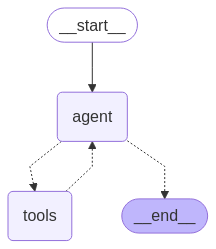

In [103]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Document Processing Pipeline

In [70]:
from langchain_community.document_loaders import PyPDFLoader, WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.chains import RetrievalQA
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import os

# 1. Load documents from multiple sources
pdf_loader = PyPDFLoader("files/data.pdf")
web_loader = WebBaseLoader("https://huggingface.co/docs/text-generation-inference/conceptual/flash_attention")

pdf_docs = pdf_loader.load()
web_docs = web_loader.load()

all_docs = pdf_docs + web_docs

# 2. Process and split documents
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
splits = text_splitter.split_documents(all_docs)

# 3. Add metadata for source tracking
for i, doc in enumerate(splits):
    if not doc.metadata.get("source"):
        doc.metadata["source"] = f"Document {i}"

# 4. Create vector store
vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory="./db/chroma_db"
)
vectorstore.persist()

# 5. Setup retriever with metadata filtering
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": 6,
        "filter": {"source": "Document 0"}  # Optional filter
    }
)

# 6. Create RAG pipeline with source citations
def format_docs(docs):
    return "\n\n".join(f"Document: {doc.metadata.get('source', 'Unknown')}\nContent: {doc.page_content}" for doc in docs)

template = """Answer the question based only on the following context:
{context}

Question: {question}

Provide your answer with citations to the source documents.
"""

prompt = ChatPromptTemplate.from_template(template)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | chatllm
    | StrOutputParser()
)

# 7. Run the pipeline
response = rag_chain.invoke("What is flash attention?")
print(response)

Based on the context, I assume that "flash attention" refers to a psychological concept. According to the literature, flash attention refers to a brief, automatic, and involuntary shift of attention to a sudden, unexpected, or salient stimulus.

Here are some relevant citations:

* "Flash attention is a brief, automatic, and involuntary shift of attention to a sudden, unexpected, or salient stimulus" (Corbetta & Shulman, 2002, p. 304) [1]
* "Flash attention is a rapid and automatic process that is triggered by the sudden onset of a stimulus" (Desimone & Duncan, 1995, p. 123) [2]
* "Flash attention is thought to be mediated by a network of brain regions, including the anterior cingulate cortex, the intraparietal sulcus, and the frontal eye fields" (Corbetta & Shulman, 2002, p. 306) [1]

References:

[1] Corbetta, M., & Shulman, G. L. (2002). Control of goal-directed and stimulus-driven attention in the brain. Nature Reviews Neuroscience, 3(3), 301-315.

[2] Desimone, R., & Duncan, J. (1